# Initialization

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


In [2]:
import sys, os
sys.path.append("/global/homes/b/bwood/machine_learning/ulissi_cnn/hpo/ocp_cgcnn/cgcnn")

In [3]:
from baselines.modules.normalizer import Normalizer
from baselines.models.cgcnn import CGCNN
from dataloader import ulissiDataset, get_data_loaders
from train_hpo import train, validate

In [4]:
#import pickle
import os
#from bisect import bisect

#from torch_geometric.data import DataLoader, InMemoryDataset
#import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
#from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GCNConv, SAGEConv
from torch.optim.lr_scheduler import MultiStepLR

# From .py's
#from normalizer import Normalizer
#from models import GCN
#from metrics import mae, AverageMeter
#from layers import CGCNNConv as CGConv
#from dataloader import CgcnnDataset, get_data_loaders
#from train_hpo import train, validate
#from train import Trainer

In [5]:
train_size = 2560
val_size = 640
test_size = 800

In [6]:
no_remain_batch_size = []
for i in range(1, 120):
    if float(train_size) % i == 0:
        no_remain_batch_size.append(i)

In [7]:
no_remain_batch_size

[1, 2, 4, 5, 8, 10, 16, 20, 32, 40, 64, 80]

# Load data and define normalizer

In [8]:
save_dir = "./voronoi_H_4k_data_splits"
if not os.path.exists("voronoi_H_4k_data_splits"):
    os.makedirs(save_dir)

In [9]:
batch_size = 80

In [10]:
train_loader, val_loader, test_loader = get_data_loaders(save_dir, batch_size)

In [11]:
# Compute mean, std of training set labels.
normalizer = Normalizer(train_loader.dataset.data.y, device)

# Build model

In [12]:
# Build model
model = CGCNN(num_atoms=train_loader.dataset.data.x.shape[-1], 
              bond_feat_dim=train_loader.dataset.data.edge_attr.shape[-1], 
              num_targets=1, 
              atom_embedding_size=46, 
              num_graph_conv_layers=8, 
              fc_feat_size=83, 
              num_fc_layers=4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr = 0.0056)
scheduler = MultiStepLR(optimizer, milestones=[100], gamma=0.1)

# Run model

In [13]:
epochs = 150

In [14]:
t_loss = [] 
t_mae = []
v_loss = []
v_mae = []
for epoch in range(1, epochs + 1):
        t_loss_i, t_mae_i = train(model, criterion, optimizer, train_loader, normalizer, device)
        v_loss_i, v_mae_i = validate(model, criterion, optimizer, val_loader, normalizer, device, mae_print=True)
        t_loss.append(t_loss_i)
        t_mae.append(t_mae_i)
        v_loss.append(v_loss_i)
        v_mae.append(v_mae_i)
        scheduler.step()

 * MAE 0.350
 * MAE 0.320
 * MAE 0.296
 * MAE 0.295
 * MAE 0.280
 * MAE 0.275
 * MAE 0.278
 * MAE 0.275
 * MAE 0.276
 * MAE 0.265
 * MAE 0.253
 * MAE 0.255
 * MAE 0.259
 * MAE 0.257
 * MAE 0.258
 * MAE 0.264
 * MAE 0.248
 * MAE 0.250
 * MAE 0.262
 * MAE 0.252
 * MAE 0.246
 * MAE 0.250
 * MAE 0.248
 * MAE 0.243
 * MAE 0.249
 * MAE 0.251
 * MAE 0.248
 * MAE 0.247
 * MAE 0.245
 * MAE 0.246
 * MAE 0.250
 * MAE 0.255
 * MAE 0.247
 * MAE 0.248
 * MAE 0.244
 * MAE 0.237
 * MAE 0.240
 * MAE 0.242
 * MAE 0.253
 * MAE 0.243
 * MAE 0.252
 * MAE 0.250
 * MAE 0.249
 * MAE 0.251
 * MAE 0.247
 * MAE 0.253
 * MAE 0.267
 * MAE 0.288
 * MAE 0.250
 * MAE 0.233
 * MAE 0.263
 * MAE 0.244
 * MAE 0.246
 * MAE 0.254
 * MAE 0.244
 * MAE 0.265
 * MAE 0.244
 * MAE 0.252
 * MAE 0.242
 * MAE 0.264
 * MAE 0.238
 * MAE 0.246
 * MAE 0.246
 * MAE 0.245
 * MAE 0.244
 * MAE 0.232
 * MAE 0.242
 * MAE 0.237
 * MAE 0.238
 * MAE 0.248
 * MAE 0.251
 * MAE 0.240
 * MAE 0.241
 * MAE 0.255
 * MAE 0.261
 * MAE 0.243
 * MAE 0.242

In [17]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

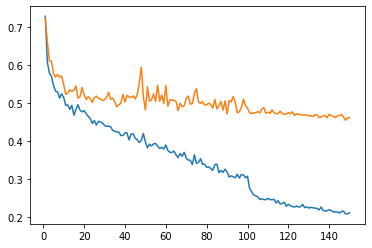

In [18]:
plt.plot(range(1,151), t_loss, range(1,151), v_loss)

In [19]:
plt.rc('savefig',dpi=500)
#plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

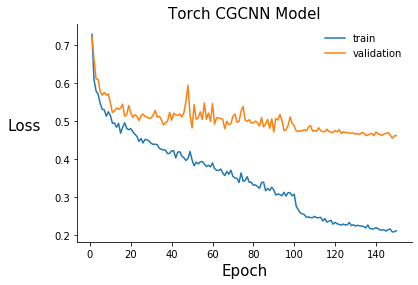

In [20]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(1,151), t_loss, range(1,151), v_loss)
#ax.plot(angles, list_kbt, '--')
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('Loss', rotation=0, labelpad=30, fontsize=15)
#ax.set_ylim(0.00, 0.14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Torch CGCNN Model', fontsize=15)
ax.legend(['train', 'validation'], frameon=False)
#plt.savefig('./plots/torch_cgcnn_losses.pdf', bbox_inches='tight', transparent=True)

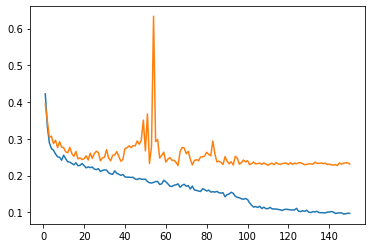

In [22]:
plt.plot(range(1,151), t_mae, range(1,151), v_mae)

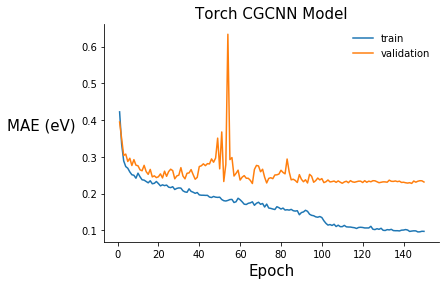

In [33]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(1,151), t_mae, range(1,151), v_mae)
#ax.plot(angles, list_kbt, '--')
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('MAE (eV)', rotation=0, labelpad=40, fontsize=15)
#ax.set_ylim(0.00, 0.14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Torch CGCNN Model', fontsize=15)
ax.legend(['train', 'validation'], frameon=False)
#plt.savefig('./plots/torch_cgcnn_mae.pdf', bbox_inches='tight', transparent=True)

In [18]:
#from baselines.common.meter import mae, Meter

In [19]:
#test_meter = Meter()

In [20]:
mae_error = 4.8
# Update meter 
meter_update_dict = { 
    "mae": mae_error, 
}
test_meter.update(meter_update_dict)

NameError: name 'test_meter' is not defined

In [ ]:
mae_error = 3.4
# Update meter 
meter_update_dict = { 
    "mae": mae_error, 
}
test_meter.update(meter_update_dict)

In [ ]:
mae_error = 2.9
# Update meter 
meter_update_dict = { 
    "mae": mae_error, 
}
test_meter.update(meter_update_dict)

In [ ]:
test_meter.mae.global_avg

In [ ]:
list_a = []